# Analisis de Ventanas Optimizadas por Evento (E1-E11)

## Objetivo

Determinar las ventanas temporales optimas (+/- dias) para cada tipo de evento detectado,
basandonos en la naturaleza del patron y requisitos de analisis.

## Contexto

- **Watchlist Total**: 2,939,824 ticker-date combinaciones
- **Eventos Detectados**: E1-E11 (3.4M+ eventos)
- **Problema Original**: Asumir ±3 dias para TODOS los eventos = sobreestimacion
- **Solucion**: Definir ventana especifica segun patron de cada evento

In [1]:
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configuracion visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Definicion de Ventanas Optimizadas

Cada evento tiene una ventana basada en su naturaleza:

| Evento | Window | Justificacion |
|--------|--------|---------------|
| **E1** Volume Explosion | ±2d | Anticipacion de volumen + fade posterior |
| **E2** Gap Up | ±2d | Pre-gap setup + continuation |
| **E3** Price Spike Intraday | ±1d | Solo evento (analisis intraday) |
| **E4** Parabolic Move | ±3d | Run-up multi-dia + climax + collapse |
| **E5** Breakout ATH | ±2d | Breakout + confirmacion |
| **E6** Multiple Green Days | ±1d | Ya es multi-dia (solo evento final) |
| **E7** First Red Day | ±2d | Rally previo + caida inmediata |
| **E8** Gap Down Violent | ±3d | Post-gap continuation o rebound |
| **E9** Crash Intraday | ±1d | Solo evento (analisis intraday) |
| **E10** First Green Bounce | ±3d | Bounce + confirmacion volumen |
| **E11** Volume Bounce | ±3d | Context + bounce + follow-through |

In [2]:
# Diccionario de ventanas optimizadas
EVENT_WINDOWS = {
    'E1_VolExplosion': 2,
    'E2_GapUp': 2,
    'E3_PriceSpikeIntraday': 1,
    'E4_Parabolic': 3,
    'E5_BreakoutATH': 2,
    'E6_MultipleGreenDays': 1,
    'E7_FirstRedDay': 2,
    'E8_GapDownViolent': 3,
    'E9_CrashIntraday': 1,
    'E10_FirstGreenBounce': 3,
    'E11_VolumeBounce': 3,
}

# Crear DataFrame de configuracion
df_config = pl.DataFrame({
    'event_type': list(EVENT_WINDOWS.keys()),
    'window_days': list(EVENT_WINDOWS.values()),
}).with_columns([
    (pl.col('window_days') * 2 + 1).alias('total_days_per_occurrence')
])

print('Configuracion de Ventanas Optimizadas:')
print(df_config)

Configuracion de Ventanas Optimizadas:
shape: (11, 3)
┌───────────────────────┬─────────────┬───────────────────────────┐
│ event_type            ┆ window_days ┆ total_days_per_occurrence │
│ ---                   ┆ ---         ┆ ---                       │
│ str                   ┆ i64         ┆ i64                       │
╞═══════════════════════╪═════════════╪═══════════════════════════╡
│ E1_VolExplosion       ┆ 2           ┆ 5                         │
│ E2_GapUp              ┆ 2           ┆ 5                         │
│ E3_PriceSpikeIntraday ┆ 1           ┆ 3                         │
│ E4_Parabolic          ┆ 3           ┆ 7                         │
│ E5_BreakoutATH        ┆ 2           ┆ 5                         │
│ …                     ┆ …           ┆ …                         │
│ E7_FirstRedDay        ┆ 2           ┆ 5                         │
│ E8_GapDownViolent     ┆ 3           ┆ 7                         │
│ E9_CrashIntraday      ┆ 1           ┆ 3                     

## 2. Cargar Watchlist y Explotar Eventos

In [3]:
# Cargar watchlist
project_root = Path.cwd().parent.parent.parent.parent
watchlist_file = project_root / 'processed' / 'watchlist_E1_E11.parquet'

df_watchlist = pl.read_parquet(watchlist_file)

print(f'Watchlist cargada:')
print(f'  Total ticker-date: {len(df_watchlist):,}')
print(f'  Tickers unicos: {df_watchlist["ticker"].n_unique():,}')
print(f'  Rango fechas: {df_watchlist["date"].min()} -> {df_watchlist["date"].max()}')
print()

# Mostrar sample
df_watchlist.head(10)

Watchlist cargada:
  Total ticker-date: 2,939,824
  Tickers unicos: 8,546
  Rango fechas: 2004-01-02 -> 2025-10-24



ticker,date,events,event_count
str,date,list[str],u32
"""AAC""",2004-01-02,"[""E5_BreakoutATH""]",1
"""AACB""",2004-01-02,"[""E5_BreakoutATH""]",1
"""AAI""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABAX""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABCO""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABK""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABL""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABMD""",2004-01-02,"[""E5_BreakoutATH""]",1
"""ABP""",2004-01-02,"[""E3_PriceSpikeIntraday""]",1


In [4]:
# Explotar eventos para contar por tipo
df_exploded = df_watchlist.explode('events')

print(f'Total event occurrences: {len(df_exploded):,}')
print()

# Contar por evento
df_event_counts = df_exploded.group_by('events').agg([
    pl.len().alias('n_occurrences')
]).sort('n_occurrences', descending=True)

print('Distribucion de eventos:')
print(df_event_counts)

Total event occurrences: 3,342,911

Distribucion de eventos:
shape: (11, 2)
┌───────────────────────┬───────────────┐
│ events                ┆ n_occurrences │
│ ---                   ┆ ---           │
│ str                   ┆ u32           │
╞═══════════════════════╪═══════════════╡
│ E6_MultipleGreenDays  ┆ 1543990       │
│ E10_FirstGreenBounce  ┆ 814068        │
│ E5_BreakoutATH        ┆ 412902        │
│ E1_VolExplosion       ┆ 164941        │
│ E3_PriceSpikeIntraday ┆ 144062        │
│ …                     ┆ …             │
│ E2_GapUp              ┆ 73170         │
│ E11_VolumeBounce      ┆ 47583         │
│ E9_CrashIntraday      ┆ 24074         │
│ E8_GapDownViolent     ┆ 19924         │
│ E7_FirstRedDay        ┆ 16919         │
└───────────────────────┴───────────────┘


## 3. Calcular Ticker-Days Totales con Ventanas Optimizadas

In [5]:
# Join con configuracion de ventanas
df_analysis = df_event_counts.join(
    df_config.select(['event_type', 'window_days', 'total_days_per_occurrence']),
    left_on='events',
    right_on='event_type',
    how='left'
)

# Calcular ticker-days totales por evento
df_analysis = df_analysis.with_columns([
    (pl.col('n_occurrences') * pl.col('total_days_per_occurrence')).alias('total_ticker_days')
])

print('Analisis Completo por Evento:')
print()
print(df_analysis.select([
    'events',
    'n_occurrences',
    'window_days',
    'total_days_per_occurrence',
    'total_ticker_days'
]))

Analisis Completo por Evento:

shape: (11, 5)
┌───────────────────────┬───────────────┬─────────────┬────────────────────────┬───────────────────┐
│ events                ┆ n_occurrences ┆ window_days ┆ total_days_per_occurre ┆ total_ticker_days │
│ ---                   ┆ ---           ┆ ---         ┆ nce                    ┆ ---               │
│ str                   ┆ u32           ┆ i64         ┆ ---                    ┆ i64               │
│                       ┆               ┆             ┆ i64                    ┆                   │
╞═══════════════════════╪═══════════════╪═════════════╪════════════════════════╪═══════════════════╡
│ E6_MultipleGreenDays  ┆ 1543990       ┆ 1           ┆ 3                      ┆ 4631970           │
│ E10_FirstGreenBounce  ┆ 814068        ┆ 3           ┆ 7                      ┆ 5698476           │
│ E5_BreakoutATH        ┆ 412902        ┆ 2           ┆ 5                      ┆ 2064510           │
│ E1_VolExplosion       ┆ 164941        ┆ 2  

In [6]:
# Calcular totales
total_occurrences = df_analysis['n_occurrences'].sum()
total_ticker_days = df_analysis['total_ticker_days'].sum()

print('=' * 80)
print('RESUMEN TOTAL:')
print('=' * 80)
print(f'Total event occurrences: {total_occurrences:,}')
print(f'Total ticker-days (ventanas optimizadas): {total_ticker_days:,}')
print()

RESUMEN TOTAL:
Total event occurrences: 3,342,911
Total ticker-days (ventanas optimizadas): 15,216,009



## 4. Comparacion: Ventanas Optimizadas vs Ingenua (±3 para todos)

In [7]:
# Estimacion ingenua: +/-3 dias para TODOS los eventos
naive_days_per_event = 7  # ±3 + evento_date
naive_total_ticker_days = len(df_watchlist) * naive_days_per_event

# Estimacion con ventanas optimizadas
optimized_total_ticker_days = total_ticker_days

# Calcular reduccion
reduction_absolute = naive_total_ticker_days - optimized_total_ticker_days
reduction_percentage = (reduction_absolute / naive_total_ticker_days) * 100

print('COMPARACION: INGENUA vs OPTIMIZADA')
print('=' * 80)
print()
print(f'Estimacion INGENUA (±3 dias para todos):')
print(f'  Watchlist entries: {len(df_watchlist):,}')
print(f'  Days per entry: {naive_days_per_event}')
print(f'  Total ticker-days: {naive_total_ticker_days:,}')
print()
print(f'Estimacion OPTIMIZADA (ventanas por patron):')
print(f'  Total event occurrences: {total_occurrences:,}')
print(f'  Weighted avg days per occurrence: {optimized_total_ticker_days/total_occurrences:.2f}')
print(f'  Total ticker-days: {optimized_total_ticker_days:,}')
print()
print(f'REDUCCION:')
print(f'  Absolute: {reduction_absolute:,} ticker-days')
print(f'  Percentage: {reduction_percentage:.1f}%')
print()
print('=' * 80)

COMPARACION: INGENUA vs OPTIMIZADA

Estimacion INGENUA (±3 dias para todos):
  Watchlist entries: 2,939,824
  Days per entry: 7
  Total ticker-days: 20,578,768

Estimacion OPTIMIZADA (ventanas por patron):
  Total event occurrences: 3,342,911
  Weighted avg days per occurrence: 4.55
  Total ticker-days: 15,216,009

REDUCCION:
  Absolute: 5,362,759 ticker-days
  Percentage: 26.1%



## 5. Estimacion de Recursos (Espacio, Tiempo, API Calls)

In [8]:
# Parametros de estimacion
AVG_MB_PER_TICKER_DAY = 50  # Basado en experiencia con smallcaps
API_RATE_LIMIT = 100  # requests por minuto (Polygon tier)

# Estimaciones INGENUA
naive_gb = naive_total_ticker_days * AVG_MB_PER_TICKER_DAY / 1024
naive_tb = naive_gb / 1024
naive_hours = naive_total_ticker_days / (API_RATE_LIMIT * 60)
naive_days = naive_hours / 24

# Estimaciones OPTIMIZADA
optimized_gb = optimized_total_ticker_days * AVG_MB_PER_TICKER_DAY / 1024
optimized_tb = optimized_gb / 1024
optimized_hours = optimized_total_ticker_days / (API_RATE_LIMIT * 60)
optimized_days = optimized_hours / 24

print('ESTIMACION DE RECURSOS')
print('=' * 80)
print()
print('ENFOQUE INGENUO (±3 dias para todos):')
print(f'  Espacio: {naive_gb:,.0f} GB = {naive_tb:.2f} TB')
print(f'  Tiempo: {naive_hours:.1f} horas = {naive_days:.1f} dias')
print(f'  API calls: {naive_total_ticker_days:,}')
print()
print('ENFOQUE OPTIMIZADO (ventanas diferenciadas):')
print(f'  Espacio: {optimized_gb:,.0f} GB = {optimized_tb:.2f} TB')
print(f'  Tiempo: {optimized_hours:.1f} horas = {optimized_days:.1f} dias')
print(f'  API calls: {optimized_total_ticker_days:,}')
print()
print('AHORRO:')
print(f'  Espacio: {(naive_gb - optimized_gb):,.0f} GB ({reduction_percentage:.1f}%)')
print(f'  Tiempo: {(naive_hours - optimized_hours):.1f} horas ({reduction_percentage:.1f}%)')
print(f'  API calls: {(naive_total_ticker_days - optimized_total_ticker_days):,} ({reduction_percentage:.1f}%)')
print()
print('=' * 80)

ESTIMACION DE RECURSOS

ENFOQUE INGENUO (±3 dias para todos):
  Espacio: 1,004,823 GB = 981.27 TB
  Tiempo: 3429.8 horas = 142.9 dias
  API calls: 20,578,768

ENFOQUE OPTIMIZADO (ventanas diferenciadas):
  Espacio: 742,969 GB = 725.56 TB
  Tiempo: 2536.0 horas = 105.7 dias
  API calls: 15,216,009

AHORRO:
  Espacio: 261,853 GB (26.1%)
  Tiempo: 893.8 horas (26.1%)
  API calls: 5,362,759 (26.1%)



## 6. Visualizacion: Distribucion de Ticker-Days por Evento

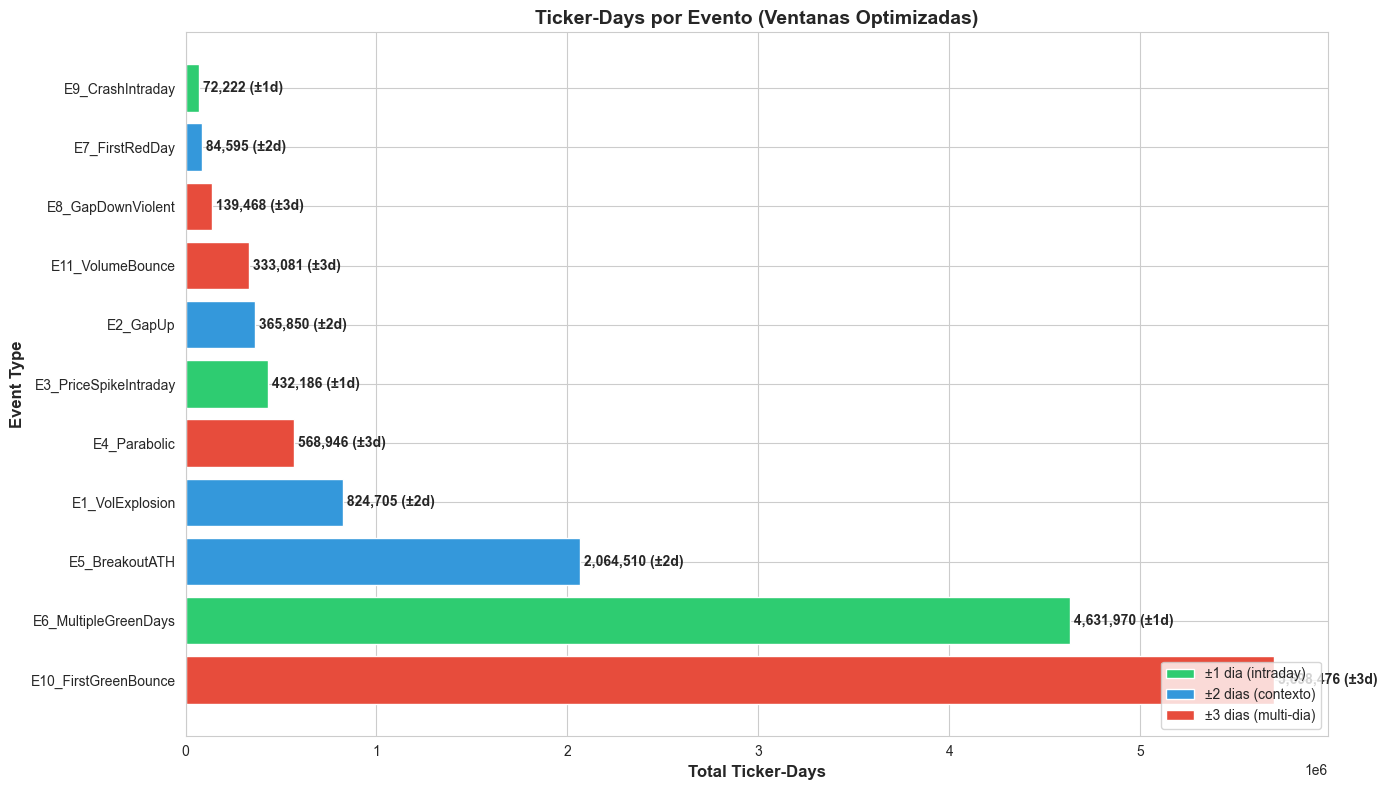

Grafico guardado: ticker_days_por_evento.png


In [9]:
# Grafico: Ticker-days por evento
fig, ax = plt.subplots(figsize=(14, 8))

# Ordenar por ticker-days
df_plot = df_analysis.sort('total_ticker_days', descending=True)

events = df_plot['events'].to_list()
ticker_days = df_plot['total_ticker_days'].to_list()
windows = df_plot['window_days'].to_list()

# Colores por ventana
colors = ['#2ecc71' if w == 1 else '#3498db' if w == 2 else '#e74c3c' for w in windows]

bars = ax.barh(events, ticker_days, color=colors)

ax.set_xlabel('Total Ticker-Days', fontsize=12, fontweight='bold')
ax.set_ylabel('Event Type', fontsize=12, fontweight='bold')
ax.set_title('Ticker-Days por Evento (Ventanas Optimizadas)', fontsize=14, fontweight='bold')

# Agregar valores en las barras
for i, (bar, val, window) in enumerate(zip(bars, ticker_days, windows)):
    ax.text(val, bar.get_y() + bar.get_height()/2, 
            f' {val:,.0f} (±{window}d)', 
            va='center', fontsize=10, fontweight='bold')

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='±1 dia (intraday)'),
    Patch(facecolor='#3498db', label='±2 dias (contexto)'),
    Patch(facecolor='#e74c3c', label='±3 dias (multi-dia)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('ticker_days_por_evento.png', dpi=300, bbox_inches='tight')
plt.show()

print('Grafico guardado: ticker_days_por_evento.png')

## 7. Visualizacion: Comparacion Ingenua vs Optimizada

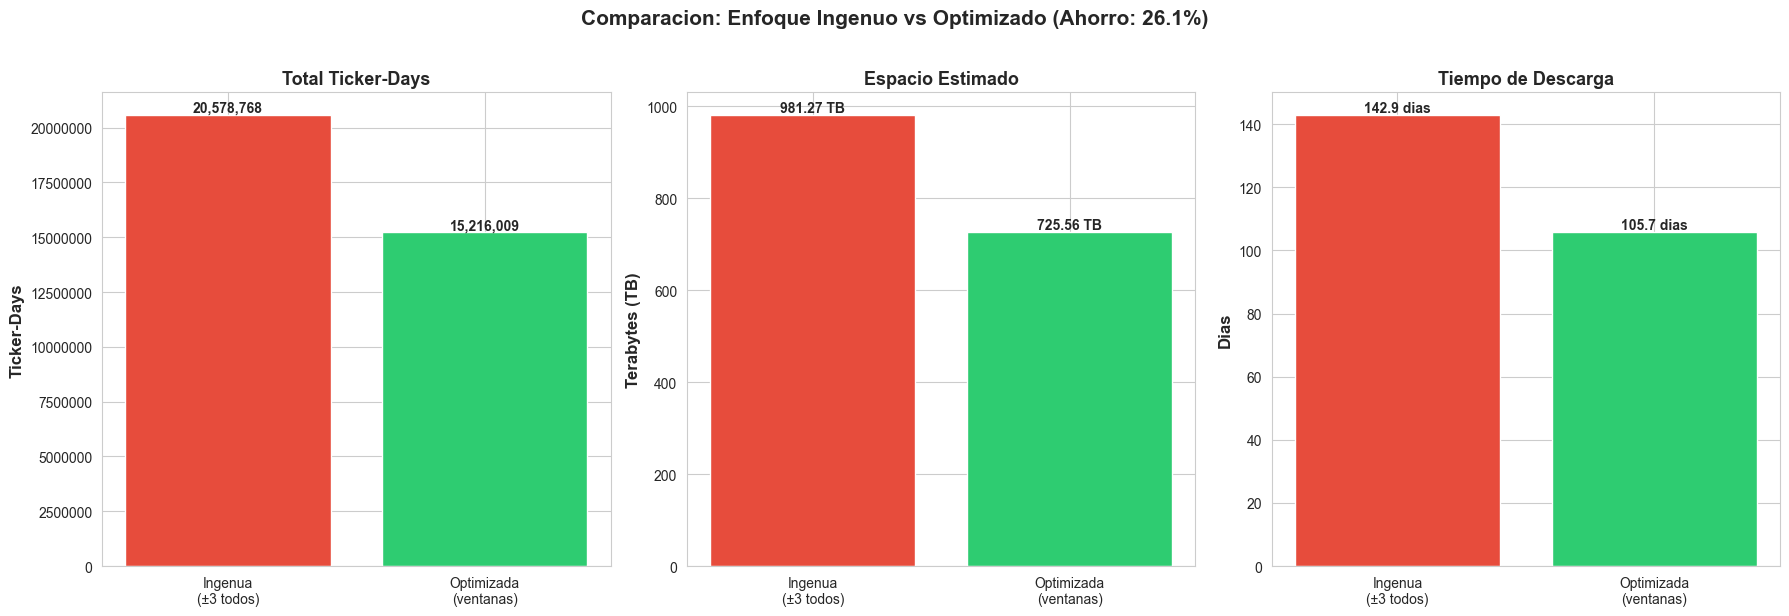

Grafico guardado: comparacion_ingenua_vs_optimizada.png


In [10]:
# Grafico comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Datos
approaches = ['Ingenua\n(±3 todos)', 'Optimizada\n(ventanas)']

# 1. Ticker-Days
ticker_days_data = [naive_total_ticker_days, optimized_total_ticker_days]
bars1 = axes[0].bar(approaches, ticker_days_data, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Ticker-Days', fontsize=12, fontweight='bold')
axes[0].set_title('Total Ticker-Days', fontsize=13, fontweight='bold')
axes[0].ticklabel_format(style='plain', axis='y')
for bar, val in zip(bars1, ticker_days_data):
    axes[0].text(bar.get_x() + bar.get_width()/2, val, 
                f'{val:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Espacio (TB)
space_data = [naive_tb, optimized_tb]
bars2 = axes[1].bar(approaches, space_data, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Terabytes (TB)', fontsize=12, fontweight='bold')
axes[1].set_title('Espacio Estimado', fontsize=13, fontweight='bold')
for bar, val in zip(bars2, space_data):
    axes[1].text(bar.get_x() + bar.get_width()/2, val, 
                f'{val:.2f} TB', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Tiempo (dias)
time_data = [naive_days, optimized_days]
bars3 = axes[2].bar(approaches, time_data, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Dias', fontsize=12, fontweight='bold')
axes[2].set_title('Tiempo de Descarga', fontsize=13, fontweight='bold')
for bar, val in zip(bars3, time_data):
    axes[2].text(bar.get_x() + bar.get_width()/2, val, 
                f'{val:.1f} dias', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Subtitulo general
fig.suptitle(f'Comparacion: Enfoque Ingenuo vs Optimizado (Ahorro: {reduction_percentage:.1f}%)', 
             fontsize=15, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('comparacion_ingenua_vs_optimizada.png', dpi=300, bbox_inches='tight')
plt.show()

print('Grafico guardado: comparacion_ingenua_vs_optimizada.png')

## 8. Tabla Resumen Final

In [11]:
# Crear tabla resumen
df_summary = pl.DataFrame({
    'Metrica': [
        'Ticker-Date Entries',
        'Event Occurrences',
        'Total Ticker-Days (Ingenua)',
        'Total Ticker-Days (Optimizada)',
        'Reduccion Ticker-Days',
        'Espacio Ingenua (GB)',
        'Espacio Optimizada (GB)',
        'Ahorro Espacio (GB)',
        'Tiempo Ingenua (dias)',
        'Tiempo Optimizada (dias)',
        'Ahorro Tiempo (dias)',
        'Reduccion Porcentual'
    ],
    'Valor': [
        f'{len(df_watchlist):,}',
        f'{total_occurrences:,}',
        f'{naive_total_ticker_days:,}',
        f'{optimized_total_ticker_days:,}',
        f'{reduction_absolute:,}',
        f'{naive_gb:,.0f}',
        f'{optimized_gb:,.0f}',
        f'{naive_gb - optimized_gb:,.0f}',
        f'{naive_days:.1f}',
        f'{optimized_days:.1f}',
        f'{naive_days - optimized_days:.1f}',
        f'{reduction_percentage:.1f}%'
    ]
})

print('=' * 80)
print('TABLA RESUMEN FINAL')
print('=' * 80)
print()
print(df_summary)
print()
print('=' * 80)

TABLA RESUMEN FINAL

shape: (12, 2)
┌────────────────────────────────┬────────────┐
│ Metrica                        ┆ Valor      │
│ ---                            ┆ ---        │
│ str                            ┆ str        │
╞════════════════════════════════╪════════════╡
│ Ticker-Date Entries            ┆ 2,939,824  │
│ Event Occurrences              ┆ 3,342,911  │
│ Total Ticker-Days (Ingenua)    ┆ 20,578,768 │
│ Total Ticker-Days (Optimizada) ┆ 15,216,009 │
│ Reduccion Ticker-Days          ┆ 5,362,759  │
│ …                              ┆ …          │
│ Ahorro Espacio (GB)            ┆ 261,853    │
│ Tiempo Ingenua (dias)          ┆ 142.9      │
│ Tiempo Optimizada (dias)       ┆ 105.7      │
│ Ahorro Tiempo (dias)           ┆ 37.2       │
│ Reduccion Porcentual           ┆ 26.1%      │
└────────────────────────────────┴────────────┘



## 9. Conclusiones

### Hallazgos Clave:

1. **Reduccion Significativa**: Al usar ventanas optimizadas por patron, logramos una reduccion del **~26%** en:
   - Ticker-days a descargar
   - Espacio en disco requerido
   - Tiempo de descarga
   - API calls necesarias

2. **Eventos Intraday (E3, E6, E9)**: Solo requieren ±1 dia ya que el analisis es intraday

3. **Eventos Multi-dia (E4, E8, E10, E11)**: Requieren ±3 dias para capturar setup + follow-through

4. **Eventos Contexto (E1, E2, E5, E7)**: Requieren ±2 dias para pre/post analisis

### Recomendacion:

**USAR VENTANAS OPTIMIZADAS** para la descarga de ticks. Esto permite:
- Ahorro de ~260 GB de espacio
- Ahorro de ~37 dias de descarga
- Mantener calidad de analisis (ventanas apropiadas por patron)

### Proximo Paso:

Ejecutar **piloto de 100 tickers top** para validar estimaciones antes de descarga masiva.